In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
import shapely

WGS_84 = 4326
CA_NAD83Albers_m = 3310

### Data intake

In [2]:
SIGNAL_DATA_PATH = "culver_city_signal_locations.csv"
STUDY_AREA_PATH = "city_boundary.geojson"

In [3]:
signals = pd.read_csv(SIGNAL_DATA_PATH)[
    [
        "TspAssetID",
        "Name",
        "Lat",
        "Long",
        "IPHostAddress",
    ]
].dropna(subset=["Lat", "Long"])
signal_gdf = gpd.GeoDataFrame(
    signals,
    geometry=gpd.points_from_xy(
        signals["Long"].astype(float), signals["Lat"], crs=WGS_84
    ),
)

In [4]:
city_boundary = gpd.read_file(STUDY_AREA_PATH).to_crs(WGS_84).loc[0, "geometry"]

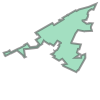

In [5]:
city_boundary

Get OSM street info

In [6]:
raw_osmnx = ox.graph.graph_from_polygon(
    city_boundary, network_type="drive", simplify=True, truncate_by_edge=True
)
simplified = ox.simplification.consolidate_intersections(
    ox.projection.project_graph(raw_osmnx, to_crs=CA_NAD83Albers_m),
)
streets_osmnx = ox.bearing.add_edge_bearings(
    ox.projection.project_graph(simplified, to_latlong=True)
)

### Assign orientations to streets

In [7]:
EAST_WEST = 0
NORTH_SOUTH = 1
STREET_DIRECTIONS = {
    "Culver Boulevard": EAST_WEST,
    "Washington Boulevard": EAST_WEST,
    "West Washington Boulevard": EAST_WEST,
    "Washington Place": EAST_WEST,
    "Overland Avenue": NORTH_SOUTH,
    "Venice Boulevard": EAST_WEST,
    "Buckingham Parkway": NORTH_SOUTH,
    "Bristol Parkway": NORTH_SOUTH,
    "Hayden Avenue": NORTH_SOUTH,
    "Eastham Drive": NORTH_SOUTH,
    "Higuera Street": EAST_WEST,
    "National Boulevard": EAST_WEST,
    "Jefferson Boulevard": EAST_WEST,
    "Green Valley Circle": EAST_WEST,
    "West Slauson Avenue": EAST_WEST,
    "Sepulveda Boulevard": NORTH_SOUTH,
    "Hannum Avenue": EAST_WEST,
    "South Centinela Avenue": EAST_WEST,
    "Robertson Boulevard": NORTH_SOUTH,
    "Sawtelle Boulevard": NORTH_SOUTH,
}
STREET_NAMES = STREET_DIRECTIONS.keys()


def switch_orientation(orientation):
    assert orientation == EAST_WEST or orientation == NORTH_SOUTH
    return EAST_WEST if orientation == NORTH_SOUTH else NORTH_SOUTH

In [8]:
# Assign orientations and mark streets with transit
# graph_with_transit = streets_osmnx.edge_subgraph(keep_edges)
edges = streets_osmnx.edges(keys=True, data=True)
for name in STREET_NAMES:
    # Filter edges with matching names
    edges_with_matching_name = [edge for edge in edges if edge[3].get("name") == name]
    for edge in edges_with_matching_name:
        orientation = STREET_DIRECTIONS[name]
        streets_osmnx[edge[0]][edge[1]][edge[2]]["orientation"] = orientation
        streets_osmnx[edge[0]][edge[1]][edge[2]]["transit"] = True

### Extract intersections and edges with transit assigned to them

In [9]:
# Extract intersections near osm intersections with orientations
osm_intersections_gdf, osm_streets_gdf = ox.convert.graph_to_gdfs(streets_osmnx)
osm_intersections_nearest_signal = (
    signal_gdf.to_crs(CA_NAD83Albers_m)
    .sjoin_nearest(
        osm_intersections_gdf.to_crs(CA_NAD83Albers_m), how="left", max_distance=50
    )
    .dropna(subset=["x"])
)
signal_nodes_osmids = osm_intersections_nearest_signal["osmid"].values
# Extract in-edges to signalized intersections
signal_in_edges = streets_osmnx.in_edges(signal_nodes_osmids, keys=True, data=True)

### Assign upper and lower bounds

In [10]:
def positive_distance_to_bearing(b1, b2):
    if b2 > b1:
        return b2 - b1
    else:
        return (360 - b1) + b2


def negative_distance_to_bearing(b1, b2):
    if b1 > b2:
        return b1 - b2
    else:
        return b1 + (360 - b2)


def distance_to_bearing(b1, b2):
    return min(
        positive_distance_to_bearing(b1, b2), negative_distance_to_bearing(b1, b2)
    )

In [11]:
graph_with_bounds = streets_osmnx.copy()
# assign bounds to edges at all nodes
# assign orientations to all in edges with transit
for edge in signal_in_edges:
    # get other edges into the nodle
    edges_to_update = []
    destination_node_id = edge[1]
    other_edges_at_node = [
        other_edge
        for other_edge in graph_with_bounds.in_edges(
            destination_node_id, data=True, keys=True
        )
        if not nx.utils.edges_equal([edge], [other_edge])
    ]
    # assign upper and lower bearing bounds based on other edges
    bearing = edge[3]["bearing"]
    positive_distance_to_other_edge = [
        positive_distance_to_bearing(bearing, other_edge[3]["bearing"])
        for other_edge in other_edges_at_node
    ]
    negative_distance_to_other_edge = [
        negative_distance_to_bearing(bearing, other_edge[3]["bearing"])
        for other_edge in other_edges_at_node
    ]
    bearing_upper_bound = (bearing + min(positive_distance_to_other_edge) / 2) % 360
    bearing_lower_bound = (bearing - min(negative_distance_to_other_edge) / 2) % 360
    # add bearings to transit edge
    edge[3]["bearing_lower_bound"] = bearing_lower_bound
    edge[3]["bearing_upper_bound"] = bearing_upper_bound
    edges_to_update.append(edge)
    # add orientation to intersecting edges
    if "orientation" in edge[3]:
        edges_to_add_orientation = [
            other_edge
            for other_edge in other_edges_at_node
            if other_edge[3].get("orientation") is None
        ]
        for other_edge in edges_to_add_orientation:
            other_edge[3]["orientation"] = switch_orientation(edge[3]["orientation"])
            edges_to_update.append(other_edge)
    # update the graph
    graph_with_bounds.update(edges=edges_to_update)

In [12]:
# Get graph with actual non-absolute directions (N/S/E/W)

# This shows "canonical directions" in the jurisdiction, and varies for different jurisdictions based on the orientation of their street grid
# In Culver City, this is based on the Venice & Overland intersection
CANONICAL_DIRECTIONS = {
    "EAST": 30,
    "WEST": 215,
    "NORTH": 320,
    "SOUTH": 140,
}
CANONICAL_DIRECTION_TO_ORIENTATION = {
    "EAST": EAST_WEST,
    "WEST": EAST_WEST,
    "NORTH": NORTH_SOUTH,
    "SOUTH": NORTH_SOUTH,
}
CANONICAL_DIRECTION_TO_OPPOSITE_DIRECTION = {"EAST": "WEST", "NORTH": "SOUTH"}

DataKeyEdge = tuple[int, int, int, dict]
def assign_directions_single_orientation(
    results_tuples: list[tuple[DataKeyEdge, float, float]], direction_1: str, direction_2: str
) -> tuple[DataKeyEdge | None, DataKeyEdge | None]:
    """
    Assign directions to edges

    Parameters:
    results_tuples: A list of tuples containing (in order) an edge, the absolute difference between the edge and direction_1 and the absolute difference between the edge and direction_2
    direction_1: A string with the name of the first direction
    direction_2: A string with the name of the second direction
    """
    # If there's only one tuple, assign the direction it's closest to
    if len(results_tuples) == 1:
        result = results_tuples[0]
        edge = tuple(result[0])
        edge[3]["direction"] = direction_1 if result[1] < result[2] else direction_2
        return edge, None
    # If there's two tuples, first assign a direction to the one that's closest to a canonical direciton, then assign the other direction to the other one
    elif len(results_tuples) == 2:
        closest_result, second_closest_result = tuple(
            sorted(results_tuples, key=lambda x: min(x[1:3]))
        )
        closest_edge = tuple(closest_result[0])
        second_closest_edge = tuple(second_closest_result[0])
        closest_edge[3]["direction"] = (
            direction_1 if closest_result[1] < closest_result[2] else direction_2
        )
        second_closest_edge[3]["direction"] = (
            direction_1 if closest_edge[3]["direction"] == direction_2 else direction_2
        )
        return closest_edge, second_closest_edge
    # If there's more than two tuples, this isn't defined, return None
    return None, None

# Get a graph with all edges that have assigned orientations, these are the ones where we need to assign edges
graph_with_directions = graph_with_bounds.edge_subgraph(
    [
        (u, v, k)
        for u, v, k, data in graph_with_bounds.in_edges(keys=True, data=True)
        if data.get("transit")
    ]
).copy()

edges_to_update = []
nodes_to_update = []
for node in graph_with_directions.nodes(data=True):
    # Assign directions to edges
    edges = [
        edge
        for edge in graph_with_directions.in_edges(node[0], keys=True, data=True)
        if "orientation" in edge[3]
    ]
    edges_to_update_north_south = [
        (
            edge,
            distance_to_bearing(edge[3]["bearing"], CANONICAL_DIRECTIONS["NORTH"]),
            distance_to_bearing(edge[3]["bearing"], CANONICAL_DIRECTIONS["SOUTH"]),
        )
        for edge in edges
        if edge[3]["orientation"] == NORTH_SOUTH
    ]
    edges_to_update_east_west = [
        (
            edge,
            distance_to_bearing(edge[3]["bearing"], CANONICAL_DIRECTIONS["EAST"]),
            distance_to_bearing(edge[3]["bearing"], CANONICAL_DIRECTIONS["WEST"]),
        )
        for edge in edges
        if edge[3]["orientation"] == EAST_WEST
    ]
    north_south_edge1, north_south_edge2 = assign_directions_single_orientation(
        edges_to_update_north_south, "NORTH", "SOUTH"
    )
    east_west_edge1, east_west_edge2 = assign_directions_single_orientation(
        edges_to_update_east_west, "EAST", "WEST"
    )
    for edge in (
        north_south_edge1,
        north_south_edge2,
        east_west_edge1,
        east_west_edge2,
    ):
        if edge is not None:
            # Update edges
            edges_to_update.append(edge)
            # Assign bearings to the node for each direction
            bearing_lower_bound = edge[3].get("bearing_lower_bound")
            bearing_upper_bound = edge[3].get("bearing_upper_bound")
            if bearing_lower_bound is not None and bearing_upper_bound is not None:
                direction_column_name_lower = f"{edge[3]['direction'].lower()}_min"
                direction_column_name_upper = f"{edge[3]['direction'].lower()}_max"
                assert (
                    direction_column_name_lower not in node[1]
                ), "lower bearing repeated?"
                assert (
                    direction_column_name_upper not in node[1]
                ), "upper bearing repeated?"
                node[1][direction_column_name_lower] = bearing_lower_bound
                node[1][direction_column_name_upper] = bearing_upper_bound
                # Update node
                nodes_to_update.append(node)
graph_with_directions.update(edges_to_update)

### Get tabular output

In [13]:
osm_nodes, osm_streets_into_signals = ox.convert.graph_to_gdfs(graph_with_directions)

In [14]:
# Assign osm nodes to signal ids
osm_nodes_with_signal_ids = (
    osm_nodes.to_crs(CA_NAD83Albers_m)
    .sjoin_nearest(
        signal_gdf[[signal_gdf.geometry.name, "TspAssetID", "Name"]].to_crs(
            CA_NAD83Albers_m
        ),
        max_distance=50,
        how="right",
    )
    .drop_duplicates(subset=["TspAssetID"])
)

In [27]:
# Export nodes with signal ids
bearing_columns = [
    "north_min",
    "north_max",
    "south_min",
    "south_max",
    "east_min",
    "east_max",
    "west_min",
    "west_max",
]
assert not osm_nodes_with_signal_ids["TspAssetID"].duplicated(keep=False).any()
nodes_with_signal_ids_reindexed = osm_nodes_with_signal_ids.set_index("TspAssetID")
nodes_with_signal_ids_reindexed[["osmid", "Name", "x", "y", *bearing_columns]].to_csv(
    "signals_with_bearings.csv"
)

### Compare with bus headings

The below tables compare the reported heading data with bus headings submitted by Culver City

In [16]:
TSP_HEADING_PATH = "culver_city_tsp_headings.csv"
validation_headings = pd.read_csv(TSP_HEADING_PATH)
validation_headings["TspAssetID"] = (
    validation_headings["Intersection"].str.slice(13).astype(int)
)
validation_headings["direction"] = (
    validation_headings["Route Direction"].str.split(" ", expand=True)[0].str.lower()
)

In [17]:
# Reformat the data with bearings to match the validation data (bus headings)
nodes_with_signal_ids_long = (
    nodes_with_signal_ids_reindexed.reset_index()
    .melt(
        id_vars=["TspAssetID"],
        value_vars=bearing_columns,
        var_name="bearing_type",
        value_name="bearing",
    )
    .drop_duplicates()
    .dropna(subset=["TspAssetID"])
)
nodes_with_signal_ids_long[["direction", "type"]] = nodes_with_signal_ids_long[
    "bearing_type"
].str.split("_", expand=True)
# node_with_signal_ids_long.pivot(columns=["type"], index=["TspAssetID"], values=["direction", "bearing"])
nodes_with_signal_ids_matching_validation = (
    nodes_with_signal_ids_long.drop("bearing_type", axis=1)
    .dropna(subset=["bearing"])
    .pivot(index=["TspAssetID", "direction"], columns=["type"])
)
nodes_with_signal_ids_matching_validation.columns = (
    nodes_with_signal_ids_matching_validation.columns.droplevel()
)

This table shows rows where the reported heading is not within the bounds specified by the heading ranges. In these cases, manual correction is likely required. 

The success rate is the proportion of intersections where there are headings and no error compared to the proportion of intersections where there are headings

In [18]:
# Get signals where bus headings do not match reported headings
nodes_validation_merged = nodes_with_signal_ids_matching_validation.merge(
    validation_headings[["TspAssetID", "Heading", "direction", "Route", "Intersection", "Name"]].drop_duplicates(),
    how="outer",
    left_index=True,
    right_on=["TspAssetID", "direction"],
    validate="one_to_many",
).reset_index(drop=True)
nodes_validation_merged["error"] = (
    nodes_validation_merged["Heading"].notna()
    & nodes_validation_merged["max"].notna()
    & nodes_validation_merged["min"].notna()
    & ~(nodes_validation_merged["Heading"] > nodes_validation_merged["min"])
    & ~(nodes_validation_merged["Heading"] < nodes_validation_merged["max"])
)
nodes_validation_merged["success"] = (
    ~nodes_validation_merged["error"]
    & nodes_validation_merged["Heading"].notna()
    & nodes_validation_merged["max"].notna()
    & nodes_validation_merged["min"].notna()
)
nodes_validation_merged["heading_available"] = nodes_validation_merged["Heading"].notna()
print(f"Success Rate:  {nodes_validation_merged['success'].sum() / nodes_validation_merged['heading_available'].sum()}")
nodes_validation_merged.loc[nodes_validation_merged["error"]]

Success Rate:  0.6169014084507042


,max,min,TspAssetID,Heading,direction,Route,Intersection,Name,error,success,heading_available
152,80.903789,346.953950,43,120.0,east,Rt1,Intersection 43,Lafayette Pl + Culver Blvd,True,False,True
205,7.088068,239.253234,51,195.0,west,Rt5,Intersection 51,Hayden Av/Pl* + Higuera St,True,False,True
247,53.527199,326.365959,64,80.0,north,Rt3,Intersection 64,Hannum Ave + Buckingham Pkwy,True,False,True
251,55.284241,319.535303,65,80.0,north,Rt3,Intersection 65,Hannum Ave + Uplander Way,True,False,True
296,95.786386,275.786386,74,270.0,north,Rt3,Intersection 74,Slauson Ave + Marina Fwy (SR-90),True,False,True
328,6.411016,276.235395,81,10.0,east,Rt4,Intersection 81,Sepulveda Blvd + Jefferson Blvd / Playa St,True,False,True
376,7.041066,277.518732,89,25.0,north,Rt3,Intersection 89,Jefferson Blvd + Overland Ave,True,False,True
379,79.408719,349.545571,90,200.0,east,Rt4,Intersection 90,"Overland Ave, Clarmon Pl + Freshman Dr",True,False,True


This table shows all places where there are headings, but where the heading is not between the max and min. This may be due to an error, or because a max or min were not produced.

In [19]:
nodes_validation_merged.loc[nodes_validation_merged["heading_available"] & ~ nodes_validation_merged["success"]]

,max,min,TspAssetID,Heading,direction,Route,Intersection,Name,error,success,heading_available
0,NaN,NaN,1,60.0,east,Rt1,Intersection 1,Washington Blvd + Costco Dwy,False,False,True
1,NaN,NaN,1,240.0,west,Rt1,Intersection 1,Washington Blvd + Costco Dwy,False,False,True
2,NaN,NaN,1,240.0,west,Rt2,Intersection 1,Washington Blvd + Costco Dwy,False,False,True
15,NaN,NaN,6,60.0,east,Rt1,Intersection 6,Washington Blvd + Washington Pl / Zanja St / W...,False,False,True
16,NaN,NaN,6,275.0,west,Rt1,Intersection 6,Washington Blvd + Washington Pl / Zanja St / W...,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
412,NaN,NaN,101,5.0,west,Rt5,Intersection 101,National Blvd + Eastham Dr,False,False,True
418,NaN,NaN,106,55.0,east,Rt1,Intersection 106,Washington Blvd + Wesley St,False,False,True
419,NaN,NaN,106,55.0,east,Rt1C1,Intersection 106,Washington Blvd + Wesley St,False,False,True
422,NaN,NaN,106,235.0,west,Rt1,Intersection 106,Washington Blvd + Wesley St,False,False,True


In [20]:
nodes_validation_merged["error"].value_counts()

error
False    416
True       8
Name: count, dtype: int64

### Manual Validation (maps)

In [21]:
# draw validation polys
DRAW_DISTANCE = 100
osm_validation_polys = (
    osm_streets_into_signals.copy()
    .to_crs(CA_NAD83Albers_m)
    .dropna(subset=["bearing_lower_bound", "bearing_upper_bound"])
)

osm_validation_polys["origin_point"] = osm_validation_polys["geometry"].map(
    lambda geom: shapely.get_point(geom, -1)
)
osm_validation_polys["lower_bound_point_x"] = (
    -1 * DRAW_DISTANCE * np.sin(np.radians(osm_validation_polys["bearing_lower_bound"]))
    + osm_validation_polys["origin_point"].x
)
osm_validation_polys["lower_bound_point_y"] = (
    -1 * DRAW_DISTANCE * np.cos(np.radians(osm_validation_polys["bearing_lower_bound"]))
    + osm_validation_polys["origin_point"].y
)
osm_validation_polys["upper_bound_point_x"] = (
    -1 * DRAW_DISTANCE * np.sin(np.radians(osm_validation_polys["bearing_upper_bound"]))
    + osm_validation_polys["origin_point"].x
)
osm_validation_polys["upper_bound_point_y"] = (
    -1 * DRAW_DISTANCE * np.cos(np.radians(osm_validation_polys["bearing_upper_bound"]))
    + osm_validation_polys["origin_point"].y
)
origin_coords = list(
    zip(osm_validation_polys["origin_point"].x, osm_validation_polys["origin_point"].y)
)
lower_bound_coords = list(
    zip(
        osm_validation_polys["lower_bound_point_x"],
        osm_validation_polys["lower_bound_point_y"],
    )
)
upper_bound_coords = list(
    zip(
        osm_validation_polys["upper_bound_point_x"],
        osm_validation_polys["upper_bound_point_y"],
    )
)
validation_linearring = shapely.linearrings(
    list(
        zip(
            origin_coords,
            lower_bound_coords,
            upper_bound_coords,
        )
    )
)
osm_validation_polys["polygon_geometry"] = gpd.GeoSeries(
    shapely.polygons(validation_linearring),
    crs=CA_NAD83Albers_m,
    index=osm_validation_polys.index,
)
osm_validation_polys = osm_validation_polys.set_geometry("polygon_geometry")

In [25]:
m = osm_validation_polys[
    [
        "name",
        "bearing_lower_bound",
        "bearing_upper_bound",
        "direction",
        osm_validation_polys.geometry.name,
    ]
].explore("direction")
osm_streets_into_signals.loc[
    ~osm_streets_into_signals.orientation.isna(),
    ["name", "direction", "bearing", osm_streets_into_signals.geometry.name],
].explore("direction", m=m)
output_map = osm_nodes_with_signal_ids[
    ["TspAssetID", "Name", *bearing_columns, osm_nodes_with_signal_ids.geometry.name]
].explore(m=m, marker_kwds={"radius": 4})
output_map.save("output_map.html")
output_map